In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import hvplot.pandas
%matplotlib inline

## Setting up Cheeseburger dataframe

In [22]:
everything = pd.read_csv(r'C:\Users\harr1\Desktop\Merged_Data_US_noJuly.csv')

everything=everything.drop(['Unnamed: 0'], axis=1)
everything

########################Setting up burger info############################

#Combining all burgers together
chzbrg = everything[everything['Menu Item']=='Cheeseburger'] 
hambrg = everything[everything['Menu Item']=='Hamburger']
abe = everything[everything['Menu Item']=='A.B.E Burger']
poivre = everything[everything['Menu Item']=='Au Poivre Burger']
cowboy = everything[everything['Menu Item']=='Cowboy Jack Burger']
swiss = everything[everything['Menu Item']=='Sauteed & Swiss Burger']

frames = [chzbrg,hambrg,abe,poivre,cowboy,swiss]
chzbrg = pd.concat(frames)

#No longer need these columns
chzbrg = chzbrg.drop(['Menu Group', 'Menu Item'], axis = 1)

#Consolodating dates to reduce duplicates
chzbrg = chzbrg.groupby('time_adjust').agg({'Item Qty': 'sum', 'Guests':'first', 'apparentTemperature':'first',  
                               'cloudCover':'first',  'dewPoint':'first', 'humidity':'first',
                                'ozone': 'first', 'pressure':'first',  'temperature':'first',  'uvIndex':'first',  
                               'visibility':'first', 'windBearing':'first',  'windGust':'first',  
                               'windSpeed':'first',  'Day_encoded':'first', 'weather':'first', 
                                'summary_num': 'first', 'hours':'first', 'month': 'first'
                                }).reset_index()
####################################Feature Engineering##############################################

#Probability of ordering a burger for every day previously
chzbrg['Prob']= chzbrg['Item Qty']/chzbrg['Guests']
chzbrg

#Probability of ordering a burger on the same day in the week prior
count = 0
prob_last = []
i=0
while count < 178:
    for each in chzbrg['Prob']:
        if count <= 6:
            prob_last.append(each)
            count = count +1
        elif count >6:
            prob_last.append(chzbrg['Prob'][i])
            count = count+1
            i = i +1
chzbrg['Prob_last'] = prob_last

#Probability of ordering a burger per day of the week averaged over 6 months
chzbrg['Prob_ave'] = chzbrg.groupby('Day_encoded')['Prob'].transform('mean')

#Number of burgers ordered per day of the week averaged over 6 months
chzbrg['Item_ave'] = chzbrg.groupby('Day_encoded')['Item Qty'].transform('mean')

#Average number of burgers ordered per day of the week per month 
chzbrg['Quant_dm']= chzbrg.groupby(['month', 'Day_encoded'])['Item Qty'].transform('mean')

#Number of guests dividing into groups of 25
guest_grp = []
for x in chzbrg['Guests']:
    if x <= 25:
        guest_grp.append(1)
    elif 25< x <= 50:
        guest_grp.append(2)
    elif 50 < x <= 75:
        guest_grp.append(3)
    elif 75< x <= 100:
        guest_grp.append(4)
    elif 100< x <= 125:
        guest_grp.append(5)
    elif 125< x <= 150:
        guest_grp.append(6)
    elif 150< x <= 175:
        guest_grp.append(7)
    elif 175< x <= 200:
        guest_grp.append(8)
    elif 200< x <= 225:
        guest_grp.append(9)
    elif 225< x <= 250:
        guest_grp.append(10)
    elif 250< x <= 275:
        guest_grp.append(11)
    elif 275< x <= 300:
        guest_grp.append(12)
    elif 300< x <= 325:
        guest_grp.append(13)
    elif 325< x <= 350:
        guest_grp.append(14)
    elif 350< x <= 375:
        guest_grp.append(15)
    elif 375< x <= 400:
        guest_grp.append(16)
    else:
        guest_grp.append(17)
        
chzbrg['guest_grp'] = guest_grp

#Average probability of ordering a burger depending on the categorized 
#amount of guests in the building that day
chzbrg['guest_grp_prob'] = chzbrg.groupby('guest_grp')['Prob'].transform('mean')

#Ave probability of ordering a burger based on guest count 
#multiplied by probability average per day of the week
chzbrg['interact']= chzbrg['guest_grp_prob'] * chzbrg['Prob_ave']
chzbrg

#Dropping nulls
null = chzbrg.isnull().sum()
chzbrg = chzbrg.dropna()

#Dropping Probability as it is not a realistic measure
chzbrg=chzbrg.drop(['Prob'], axis=1)
chzbrg.time_adjust.max()

178.0

## End feature engineering

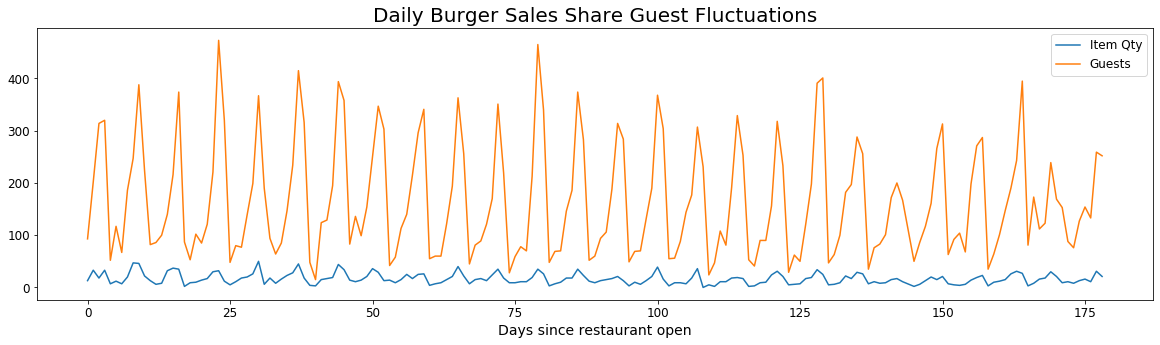

In [23]:
plt.figure(figsize=(20,5))
plt.title('Daily Burger Sales Share Guest Fluctuations', fontsize=20)
plt.plot('time_adjust', 'Item Qty', data=chzbrg)
plt.plot('time_adjust', 'Guests', data=chzbrg)
plt.xlabel('Days since restaurant open', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.show()

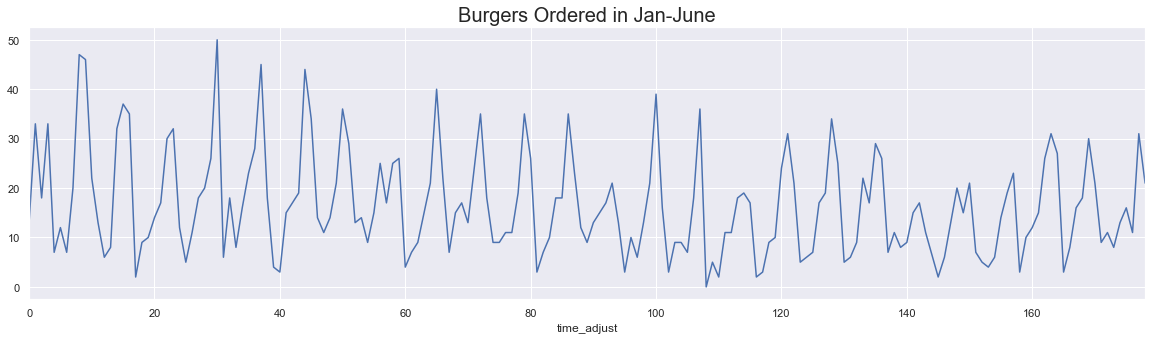

In [24]:
import seaborn as sns

import seaborn as sns; sns.set()

plt.figure(figsize= (20,5))
plt.title('Burgers Ordered in Jan-June', fontsize=20)
plt.xlabel('Days in July')
chzbrg.groupby(['time_adjust'])['Item Qty'].sum().plot()
plt.show()

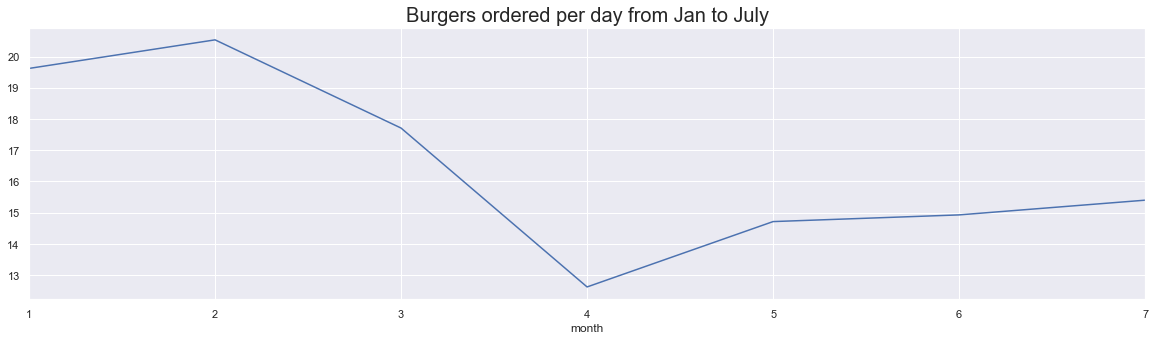

In [25]:

plt.figure(figsize= (20,5))
plt.title('Burgers ordered per day from Jan to July', fontsize=20)
chzbrg.groupby(['month'])['Quant_dm'].mean().plot()
plt.show()
#plt.ylim(0, 100)

# Modeling Cheeseburgers

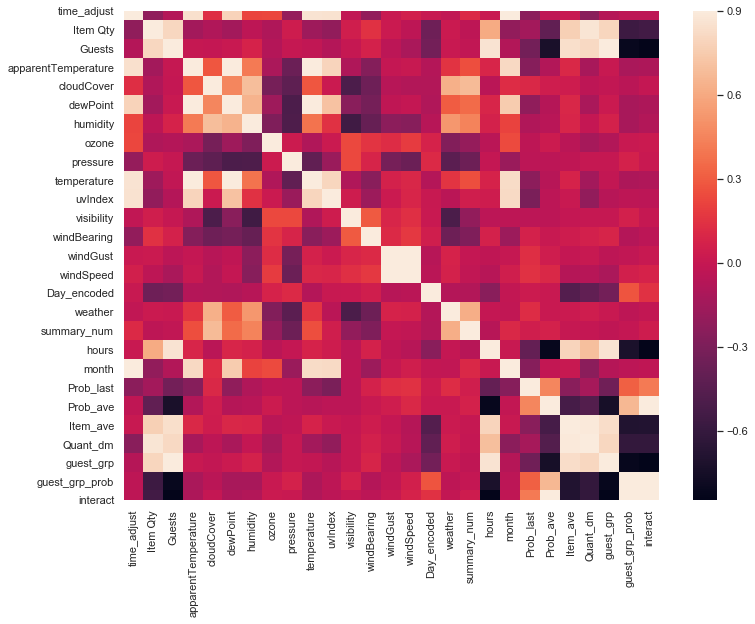

In [26]:
corrmat = chzbrg.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9)
plt.show()

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets

In [28]:
chzbrg.to_csv(r'C:\Users\harr1\Desktop\Prediction_data_US2.csv')

In [29]:
#Model including all variables
data = chzbrg.drop(['Item Qty'], axis = 1)
target = chzbrg['Item Qty']

RandForest= ensemble.RandomForestRegressor()

RandForest.fit(data,target)

RandForest.feature_importances_
RandForest_ft_series = pd.Series(data=RandForest.feature_importances_, index=data.columns)
###################################
sorted_series = RandForest_ft_series.sort_values(ascending = False)
sorted_series

c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Quant_dm               0.612616
Guests                 0.173500
interact               0.026573
guest_grp              0.017174
ozone                  0.016928
dewPoint               0.015641
windGust               0.015640
humidity               0.013451
windBearing            0.013077
apparentTemperature    0.011358
temperature            0.010863
visibility             0.010688
pressure               0.009705
time_adjust            0.009515
windSpeed              0.008798
Prob_last              0.006144
summary_num            0.005585
cloudCover             0.005447
guest_grp_prob         0.004266
Prob_ave               0.003878
month                  0.002497
weather                0.002187
Day_encoded            0.002068
uvIndex                0.001155
Item_ave               0.000802
hours                  0.000443
dtype: float64

In [30]:
#Setting up three different models

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(data, target, test_size =.10, random_state=42)


#Medium model
data_m = chzbrg[['time_adjust', 'Quant_dm','Guests', 'guest_grp_prob','Day_encoded', 'dewPoint', 'apparentTemperature', 'temperature']]
target_m = chzbrg['Item Qty']
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(data_m, target_m, test_size =.10, random_state=42)


#Super simple model
data_s=chzbrg[['Guests','Quant_dm', 'guest_grp_prob']]
target_s=chzbrg[['Item Qty']]
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(data_s,target_s,test_size=.10, random_state=42)

#Custom data based on what I think would affect a model most
data_me=chzbrg[['Guests', 'hours', 'Quant_dm', 'time_adjust', 'interact', 'guest_grp_prob', 'guest_grp']]
target_me=chzbrg[['Item Qty']]
x_train_me, x_test_me, y_train_me, y_test_me = train_test_split(data_me,target_me,test_size=.10, random_state=42)


# Linear Regression = best performing model
Custom model shows best performance with R^2 = 0.807 and Stdev = .084

In [31]:
#most of the variables
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
#Long data

long_val_scores = cross_val_score(lm, data,target,cv=10, scoring = 'explained_variance')
print('Long mean: ' , long_val_scores.mean())
print('Long std: ' , long_val_scores.std())
#print('Prediction:', lm.predict(x_test_l))

#Medium data

med_val_scores= cross_val_score(lm, data_m,target_m,cv=10, scoring = 'explained_variance')
print('\nMed mean: ' , med_val_scores.mean())
print('Med std: ' , med_val_scores.std())
#print('Prediction:', lm.predict(x_test_m))


#Short data

short_val_scores= cross_val_score(lm, data_s,target_s,cv=10, scoring = 'explained_variance')
print('\nShort mean: ' , short_val_scores.mean())
print('Short std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))

#mine

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

short_val_scores= cross_val_score(lm, data_me,target_me,cv=10, scoring = 'explained_variance')
print('\nMy mean: ' , short_val_scores.mean())
print('My std: ' , short_val_scores.std())


Long mean:  0.7727890372705044
Long std:  0.09957335562725718

Med mean:  0.7690116675177944
Med std:  0.07227400451669679

Short mean:  0.7797056560238809
Short std:  0.07880316846985734

My mean:  0.8074785059630312
My std:  0.08381036585347203


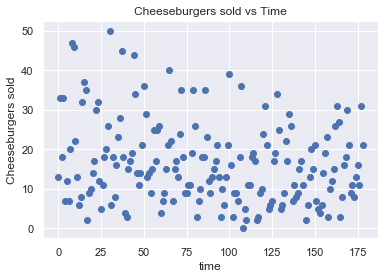

In [32]:
plt.scatter(x = chzbrg['time_adjust'], y = chzbrg['Item Qty'])
plt.title('Cheeseburgers sold vs Time')
plt.xlabel('time')
plt.ylabel('Cheeseburgers sold')
plt.show()

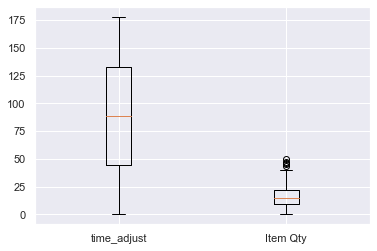

In [33]:
#Checking for outliers
plt.boxplot([chzbrg.time_adjust, chzbrg['Item Qty']])
plt.xticks([1,2], ['time_adjust','Item Qty'])
plt.show()

# Huber Regression 
Custom model shows best performance with R^2 = 0.800 and Stdev = .076

In [34]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

# #long model

long_val_scores = cross_val_score(hr, data,target,cv=10, scoring = 'explained_variance')
print('Long mean: ' , long_val_scores.mean())
print('Long std: ' , long_val_scores.std())

#medium model
med_val_scores= cross_val_score(hr, data_m,target_m,cv=10, scoring = 'explained_variance')
print('\nMed mean: ' , med_val_scores.mean())
print('Med std: ' , med_val_scores.std())
#print('Prediction:', lm.predict(x_test_m))

#Short data

short_val_scores= cross_val_score(hr, data_s,target_s,cv=10, scoring = 'explained_variance')
print('\nShort mean: ' , short_val_scores.mean())
print('Short std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))

#My data

short_val_scores= cross_val_score(hr, data_me,target_me,cv=10, scoring = 'explained_variance')
print('\nMy mean: ' , short_val_scores.mean())
print('my std: ' , short_val_scores.std())
#print('Prediction:', lm.predict(x_test_s))



Long mean:  0.7814090437160865
Long std:  0.06771942347753367

Med mean:  0.7710711848049229
Med std:  0.07373737482167034


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversio


Short mean:  0.7808872020591809
Short std:  0.06875305070798743


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversio


My mean:  0.8007892845732819
my std:  0.07582740959250467


# Ridge Regression 

Custom model shows best performance with R^2 = 0.801 and Stdev = .083

In [35]:
#long data
from sklearn.linear_model import RidgeCV

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data, target)
print ('all data alpha:', find_alpha.alpha_)

#medium data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_m, target_m)
print ('medium data alpha:', find_alpha.alpha_)


#short data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_s, target_s)
print ('short data alpha:', find_alpha.alpha_)

# #my data

find_alpha = RidgeCV(alphas=[0.02, 0.01, 0.001, 0.25, 0.50, 1.0, 1.5, 10, 24, 100]).fit(data_me, target_me)
print ('short data alpha:', find_alpha.alpha_)




all data alpha: 0.01
medium data alpha: 0.01
short data alpha: 0.01
short data alpha: 0.001


In [36]:
#long data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data, target, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))

#nedium data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_m, target_m, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean med data:', np.mean(cross_variable))
print ('Stdv med data:',np.std(cross_variable))


#simple data
ridgeregr = linear_model.Ridge(alpha = .01, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_s, target_s, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean short data:', np.mean(cross_variable))
print ('Stdv short data:',np.std(cross_variable))

# #my data
ridgeregr = linear_model.Ridge(alpha = .001, fit_intercept = False)


cross_variable=cross_val_score(ridgeregr, data_me, target_me, cv=10, scoring = 'explained_variance')
print ('\nOptimized alphas')
print('Cross Validation: \n', cross_variable)
print ('Mean my data:', np.mean(cross_variable))
print ('Stdv my data:',np.std(cross_variable))


Optimized alphas
Cross Validation: 
 [0.75900785 0.82389571 0.83966775 0.83231412 0.91423621 0.80143386
 0.71061324 0.83346406 0.7237489  0.64185158]
Mean all data: 0.7880233287406871
Stdv all data: 0.07511434138500953

Optimized alphas
Cross Validation: 
 [0.69192609 0.73419305 0.79023157 0.80602638 0.94775933 0.79869854
 0.69501684 0.75969134 0.79324515 0.69513375]
Mean med data: 0.7711922046570813
Stdv med data: 0.07305251305769764

Optimized alphas
Cross Validation: 
 [0.68401014 0.75196662 0.78274928 0.82928748 0.95067032 0.82837739
 0.69328805 0.75909861 0.790822   0.68349477]
Mean short data: 0.775376465896441
Stdv short data: 0.07815235197953734

Optimized alphas
Cross Validation: 
 [0.75656125 0.80883867 0.84855049 0.85676917 0.94812103 0.81880212
 0.72640324 0.84132138 0.78615017 0.62297922]
Mean my data: 0.8014496733576404
Stdv my data: 0.08274623521131347


# Gradient Boost

Custom model shows best performance with R^2 = 0.718 and Stdev = .101

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope


#Long data
Regressor_l = GradientBoostingRegressor( learning_rate = .07110387186724863,
                          max_depth = 1,
                          max_features = 1,
                          min_samples_leaf = 5,
                          n_estimators = 945,
                          random_state = 42
                                       )
Regressor_l.fit(x_train_l,y_train_l)


cross_variable=cross_val_score(Regressor_l, data, target, cv=10, scoring = 'explained_variance')
print('Cross Validation: \n', cross_variable)
print ('Mean all data:', np.mean(cross_variable))
print ('Stdv all data:',np.std(cross_variable))


# Medium
Regressor = GradientBoostingRegressor( learning_rate = 0.06920001196611554,
                          max_depth = 4,
                          max_features = 2,
                          min_samples_leaf = 4,
                          n_estimators = 229,
                          random_state = 42
                                       )

Regressor.fit(x_train_m,y_train_m)

cross_variable=cross_val_score(Regressor, data_m, target_m, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean med data:', np.mean(cross_variable))
print ('Stdv med data:',np.std(cross_variable))

#short
params = {'n_estimators': 189,
            'max_depth': 6,
           'max_features':3,
         'random_state':42}

Regressor_s = ensemble.GradientBoostingRegressor(**params)



cross_variable=cross_val_score(Regressor_s, data_s, target_s, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean s data:', np.mean(cross_variable))
print ('Stdv s data:',np.std(cross_variable))

#mine
Regressor_me = GradientBoostingRegressor( learning_rate =  0.234028009577632,
                          max_depth = 1,
                          max_features = 5,
                          min_samples_leaf = 9,
                          n_estimators = 141,
                          random_state = 42
                                       )
# fit
Regressor_me.fit(x_train_me,y_train_me)

cross_variable=cross_val_score(Regressor_me, data_me, target_me, cv=10, scoring = 'explained_variance')
print('\nCross Validation: \n', cross_variable)
print ('Mean me data:', np.mean(cross_variable))
print ('Stdv me data:',np.std(cross_variable))




Cross Validation: 
 [0.65906264 0.74582907 0.7530754  0.806491   0.95701145 0.75151095
 0.63687476 0.74972809 0.50904485 0.66370989]
Mean all data: 0.7232338092996472
Stdv all data: 0.11201883088403354

Cross Validation: 
 [0.66329878 0.60792406 0.77800417 0.86578163 0.91821977 0.79870194
 0.63181766 0.69016945 0.58689682 0.53943813]
Mean med data: 0.7080252403231847
Stdv med data: 0.11976183381507931


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensem


Cross Validation: 
 [0.57740319 0.47900711 0.68462286 0.79529447 0.81510086 0.71228376
 0.62321517 0.30405902 0.37374901 0.30414248]
Mean s data: 0.5668877921241581
Stdv s data: 0.18308573886041873


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensem


Cross Validation: 
 [0.70703999 0.79879877 0.83814976 0.81976331 0.88142093 0.7977989
 0.6982478  0.81114395 0.57932332 0.66983107]
Mean me data: 0.7601517795061209
Stdv me data: 0.0879569492329334


# Random Forest

Custom model shows best performance with R^2 = 0.721 and Stdev = .136

In [108]:
#optimizing parameters: had very little effect

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv =3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
lrg_fit = rf_random.fit(x_train_l, y_train_l)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [109]:
lrg_fit=rf_random.fit(x_train_l, y_train_l)
m_fit = rf_random.fit(x_train_m, y_train_m)
s_fit = rf_random.fit(x_train_s, y_train_s)
me_fit=rf_random.fit(x_train_me, y_train_me)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [110]:
#lrg_fit.best_params_
print (lrg_fit.best_params_)
print (m_fit.best_params_)
print (s_fit.best_params_)
print(me_fit.best_params_)

{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [111]:

#all data
params={'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

RandForest= ensemble.RandomForestRegressor(**params)


cross_variable=cross_val_score(RandForest, data, target, cv=10)
print('Cross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

#Medium data

params={'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_m, target_m, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

#Short data

params={'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}
RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_s, target_s, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

#Custom data

params={'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}
RandForest= ensemble.RandomForestRegressor(**params)

cross_variable=cross_val_score(RandForest, data_me, target_me, cv=10)
print('\nCross Validation: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))


Cross Validation: 
 [0.58853662 0.6626521  0.77940878 0.8130222  0.940475   0.76566514
 0.52933479 0.77271973 0.53629052 0.56021985]
Mean: 0.6948324744482457
std: 0.13248618253150127

Cross Validation: 
 [0.61339228 0.59953063 0.75908686 0.80489243 0.91600257 0.77412654
 0.57029786 0.7379779  0.63214212 0.50276655]
Mean: 0.6910215744394133
std: 0.12050107714674


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\pytho


Cross Validation: 
 [0.60158354 0.67991485 0.80852045 0.84514865 0.9287791  0.80328321
 0.43528109 0.728879   0.60911484 0.60059684]
Mean: 0.7041101580324746
std: 0.13957922291408068


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\harr1\appdata\local\programs\pytho


Cross Validation: 
 [0.58680981 0.69397605 0.82686907 0.8602859  0.94292926 0.81640039
 0.54139979 0.78035023 0.56210542 0.62051559]
Mean: 0.7231641506479256
std: 0.1337072940284596


# XGBoost

Custom model shows best performance with R^2 = 0.801 and Stdev = .083

In [112]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [113]:
xgb = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
cross_variable=cross_val_score(xgb, data, target, cv=10)
print('\nCross Validation long: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

cross_variable=cross_val_score(xgb, data_m, target_m, cv=10)
print('\nCross Validation medium: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

cross_variable=cross_val_score(xgb, data_s, target_s, cv=10)
print('\nCross Validation short: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))

cross_variable=cross_val_score(xgb, data_me, target_me, cv=10)
print('\nCross Validation short: \n', cross_variable)
print ('Mean:', np.mean(cross_variable))
print ('std:',np.std(cross_variable))



[23:45:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Cross Validation long: 
 [0.68592558 0.76398509 0.80199562 0.84571346 0.93766493 0.70244648
 0.56461532 0.85368991 0.57285016 0.54540895]
Mean: 0.7274295511988046
std: 0.12919348972036945
[23:45:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:45:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Cross Validation medium: 
 [0.67010869 0.5797624  0.76854942 0.82244656 0.91115129 0.71047002
 0.56519838 0.77020208 0.53971901 0.57813479]
Mean: 0.6915742637033505
std: 0.11944381294868188
[23:45:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:45:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

# Prediction Time!

In [4]:
#July Data

guest_count = [58,115,89,0,89,231,
              182,42,78,77,128,159,229,
              390,80]
               

total_df = pd.DataFrame()

days_passed = 0
i=0

from glob import glob

for file in glob(r'C:\Users\harr1\Desktop\Union Straw July\*csv'):
        

    df = pd.read_csv(file, index_col = 0)
    
#Dropping empty/summary rows and superfluous information
    df = df.dropna(subset = ['Menu Item'])
    df_shrt = df[['Menu Group', 'Menu Item', 'Item Qty']]

#Assigning date for dataframe
    open_date= "07/01/19"
    opening_date_dt = datetime.datetime.strptime(open_date, "%m/%d/%y")

    end_date = opening_date_dt + datetime.timedelta(days=days_passed)

    df_shrt['Date'] = end_date
    df_shrt['DOTW'] = end_date.strftime("%A")
    
    df_shrt['Guests'] = guest_count[i]
    
    total_df = total_df.append(df_shrt)
    
    days_passed = days_passed+1
    i= i +1
    
   
total_df = total_df.replace('Sandwiches','Sandwiches & Salads')
July = total_df.replace('Salads', 'Sandwiches & Salads')
July['Menu Group'].nunique()


from sklearn.preprocessing import LabelEncoder
July['Day_encoded'] = LabelEncoder().fit_transform(July['DOTW'])
July = July.drop(['DOTW'], axis = 1)

hours =[]
for each in July['Day_encoded']:
    if each == 0:
        hours.append(6)
    elif each == 1:
        hours.append(5)
    elif each == 2:
        hours.append(12)
    elif each ==3:
        hours.append(10.5)
    elif each ==4:
        hours.append(6)
    elif each == 5:
        hours.append(5)
    else:
        hours.append(5)

July['hours']=hours
July.hours.max()

July.to_csv(r'C:\Users\harr1\Desktop\July_data2.csv')
################################################################################
everything = pd.read_csv(r'C:\Users\harr1\Desktop\July_data2.csv')

everything

everything=everything.drop(['Master ID'], axis=1)
everything

########################Setting up burger info############################
chzbrg = everything[everything['Menu Item']=='Cheeseburger'] 
hambrg = everything[everything['Menu Item']=='Hamburger']
abe = everything[everything['Menu Item']=='A.B.E Burger']
poivre = everything[everything['Menu Item']=='Au Poivre Burger']
cowboy = everything[everything['Menu Item']=='Cowboy Jack Burger']
swiss = everything[everything['Menu Item']=='Sauteed & Swiss Burger']

frames = [chzbrg,hambrg,abe,poivre,cowboy,swiss]
chzbrg = pd.concat(frames)

chzbrg = chzbrg.drop(['Menu Group', 'Menu Item'], axis = 1)
############################################################

#Consolodating dates for no duplicates
chzbrg = chzbrg.groupby('Date').agg({'Item Qty': 'sum', 'Guests':'first',   
                               'Day_encoded':'first', 'hours':'first'
                                }).reset_index()
####################################Feature Engineering#########################

#Probability of ordering a burger for every day previously

time_adjust = []
count = 179
for each in chzbrg['Date']:
    time_adjust.append(count)
    count = count+1
    
chzbrg['time_adjust'] = time_adjust

month = []
for each in chzbrg['time_adjust']:
    if each <= 28:
        month.append(1)
    elif 28<each<=56:
        month.append(2)
    elif 56<each<=87:
        month.append(3)
    elif 88<each<=117:
        month.append(4)
    elif 118<each<148:
        month.append(5)
    elif 149<each<178:
        month.append(6)
    else:
        month.append(7)
        
chzbrg['month']=month


chzbrg['Prob']= chzbrg['Item Qty']/chzbrg['Guests']
chzbrg

#Probability of ordering a burger on the same day in the week prior
count = 178
prob_last = []
i=0
while count < 193:
    for each in chzbrg['Prob']:
        if count <= 6:
            prob_last.append(each)
            count = count +1
        elif count >6:
            prob_last.append(chzbrg['Prob'][i])
            count = count+1
            i = i +1
len(prob_last)
chzbrg['Prob_last'] = prob_last

#Probability of ordering a burger per day of the week averaged over 6 months
chzbrg['Prob_ave'] = chzbrg.groupby('Day_encoded')['Prob'].transform('mean')

#Number of burgers ordered per day of the week averaged over 6 months
chzbrg['Item_ave'] = chzbrg.groupby('Day_encoded')['Item Qty'].transform('mean')

#Average number of burgers ordered per day of the week per month 
chzbrg['Quant_dm']= chzbrg.groupby(['month', 'Day_encoded'])['Item Qty'].transform('mean')

#Number of guests dividing into groups of 25
guest_grp = []
for x in chzbrg['Guests']:
    if x <= 25:
        guest_grp.append(1)
    elif 25< x <= 50:
        guest_grp.append(2)
    elif 50 < x <= 75:
        guest_grp.append(3)
    elif 75< x <= 100:
        guest_grp.append(4)
    elif 100< x <= 125:
        guest_grp.append(5)
    elif 125< x <= 150:
        guest_grp.append(6)
    elif 150< x <= 175:
        guest_grp.append(7)
    elif 175< x <= 200:
        guest_grp.append(8)
    elif 200< x <= 225:
        guest_grp.append(9)
    elif 225< x <= 250:
        guest_grp.append(10)
    elif 250< x <= 275:
        guest_grp.append(11)
    elif 275< x <= 300:
        guest_grp.append(12)
    elif 300< x <= 325:
        guest_grp.append(13)
    elif 325< x <= 350:
        guest_grp.append(14)
    elif 350< x <= 375:
        guest_grp.append(15)
    elif 375< x <= 400:
        guest_grp.append(16)
    else:
        guest_grp.append(17)
        
chzbrg['guest_grp'] = guest_grp

#Average probability of ordering a burger depending on the categorized 
#amount of guests in the building that day
chzbrg['guest_grp_prob'] = chzbrg.groupby('guest_grp')['Prob'].transform('mean')

#Ave probability of ordering a burger based on guest count 
#multiplied by probability average per day of the week
chzbrg['interact']= chzbrg['guest_grp_prob'] * chzbrg['Prob_ave']
chzbrg

#Dropping nulls
null = chzbrg.isnull().sum()
chzbrg = chzbrg.dropna()

#Dropping Probability as it is not a realistic measure
chzbrg=chzbrg.drop(['Prob'], axis=1)
chzbrg


c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\harr1\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,Date,Item Qty,Guests,Day_encoded,hours,time_adjust,month,Prob_last,Prob_ave,Item_ave,Quant_dm,guest_grp,guest_grp_prob,interact
0,2019-07-01,6.0,58,1,5.0,179,7,0.103448,0.122975,6.666667,6.666667,3,0.103448,0.012722
1,2019-07-02,23.0,115,5,5.0,180,7,0.200000,0.196154,19.000000,19.000000,5,0.200000,0.039231
2,2019-07-03,17.0,89,6,5.0,181,7,0.191011,0.147454,12.500000,12.500000,4,0.137162,0.020225
4,2019-07-05,11.0,89,0,6.0,183,7,0.123596,0.130980,16.500000,16.500000,4,0.137162,0.017966
5,2019-07-06,20.0,231,2,12.0,184,7,0.086580,0.115342,26.500000,26.500000,10,0.115342,0.013304
6,2019-07-07,10.0,182,3,10.5,185,7,0.054945,0.055678,16.000000,16.000000,8,0.054945,0.003059
7,2019-07-08,8.0,42,1,5.0,186,7,0.190476,0.122975,6.666667,6.666667,2,0.190476,0.023424
8,2019-07-09,15.0,78,5,5.0,187,7,0.192308,0.196154,19.000000,19.000000,4,0.137162,0.026905
9,2019-07-10,8.0,77,6,5.0,188,7,0.103896,0.147454,12.500000,12.500000,4,0.137162,0.020225
10,2019-07-11,17.0,128,4,6.0,189,7,0.132812,0.132812,8.500000,8.500000,6,0.132812,0.017639


In [6]:
from sklearn.model_selection import train_test_split
data_me=chzbrg[['Guests', 'hours', 'Quant_dm', 'time_adjust', 'interact', 'guest_grp_prob', 'guest_grp']]
target_me=chzbrg[['Item Qty']]
x_train_me, x_test_me, y_train_me, y_test_me = train_test_split(data_me,target_me,test_size=.10, random_state=42)


from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm.fit(data_me, target_me)
pred = lm.predict(data_me)

print("x={}, Predicted = {}".format(target_me,pred))

# Final=pd.DataFrame

# Final.concat(fit, prediction_df)
type(target_me)

chzbrg['time_adjust']

x=    Item Qty
0        6.0
1       23.0
2       17.0
4       11.0
5       20.0
6       10.0
7        8.0
8       15.0
9        8.0
10      17.0
11      22.0
12      33.0
13      22.0
14       6.0, Predicted = [[ 4.14649732]
 [23.25629887]
 [11.65818825]
 [13.34906467]
 [26.0419548 ]
 [10.55824902]
 [ 9.4232484 ]
 [16.14694111]
 [12.82892355]
 [13.13866912]
 [19.21170576]
 [25.67393638]
 [23.85799138]
 [ 8.70833138]]


0     179
1     180
2     181
4     183
5     184
6     185
7     186
8     187
9     188
10    189
11    190
12    191
13    192
14    193
Name: time_adjust, dtype: int64

In [7]:
pred = pred.tolist()
flat_list = []
for sublist in pred:
    for item in sublist:
        flat_list.append(item)
flat_list

[4.146497323794154,
 23.256298874933144,
 11.658188253741029,
 13.349064670002795,
 26.041954801140555,
 10.558249015066549,
 9.423248395454518,
 16.146941106032273,
 12.828923545242928,
 13.138669116657054,
 19.211705758932666,
 25.673936380758484,
 23.857991381499886,
 8.708331376743951]

In [8]:
flat_list.insert(3, 'NaN')

In [9]:
predict = pd.Series(flat_list)

Final = pd.concat([target_me, predict], axis=1, sort=False)

date = []
date_rng = pd.date_range(start='7/1/2019', end='7/15/2019', freq='D')
date.append(date_rng)

Final = Final.set_index(date)
Final.index.name = 'Date'


# Final['Date'] = datetime.date(Final.year, Final.month, Final.day)

In [10]:
Final = Final.dropna()
Final = Final.rename(columns={'Item Qty': 'Burgers Sold', 0:'Predicted'})

Final

,Burgers Sold,Predicted
Date,,
2019-07-01,6.0,4.1465
2019-07-02,23.0,23.2563
2019-07-03,17.0,11.6582
2019-07-05,11.0,13.3491
2019-07-06,20.0,26.042
2019-07-07,10.0,10.5582
2019-07-08,8.0,9.42325
2019-07-09,15.0,16.1469
2019-07-10,8.0,12.8289


In [11]:
Diff = Final['Burgers Sold']-Final['Predicted']
Final['Difference'] = Diff
Final['Abs Difference'] = abs(Diff)
Final['Percent of Sold'] = (Final['Difference']/Final['Burgers Sold'])*100
Final['Abs Percent'] = (Final['Abs Difference']/Final['Burgers Sold'])*100
Final = Final.dropna()
Final

,Burgers Sold,Predicted,Difference,Abs Difference,Percent of Sold,Abs Percent
Date,,,,,,
2019-07-01,6.0,4.1465,1.8535,1.8535,30.8917,30.8917
2019-07-02,23.0,23.2563,-0.256299,0.256299,-1.11434,1.11434
2019-07-03,17.0,11.6582,5.34181,5.34181,31.4224,31.4224
2019-07-05,11.0,13.3491,-2.34906,2.34906,-21.3551,21.3551
2019-07-06,20.0,26.042,-6.04195,6.04195,-30.2098,30.2098
2019-07-07,10.0,10.5582,-0.558249,0.558249,-5.58249,5.58249
2019-07-08,8.0,9.42325,-1.42325,1.42325,-17.7906,17.7906
2019-07-09,15.0,16.1469,-1.14694,1.14694,-7.64627,7.64627
2019-07-10,8.0,12.8289,-4.82892,4.82892,-60.3615,60.3615


In [136]:
import hvplot.pandas
Final.hvplot.scatter(x='Date', y=['Burgers Sold', 'Predicted'], legend= 'left', title='Burgers Sold vs Predicted')


:NdOverlay   [Variable]
   :Scatter   [Date]   (value)

In [12]:
Final.loc['ave'] = Final.mean()
Final

,Burgers Sold,Predicted,Difference,Abs Difference,Percent of Sold,Abs Percent
Date,,,,,,
2019-07-01 00:00:00,6.000000,4.1465,1.8535,1.8535,30.8917,30.8917
2019-07-02 00:00:00,23.000000,23.2563,-0.256299,0.256299,-1.11434,1.11434
2019-07-03 00:00:00,17.000000,11.6582,5.34181,5.34181,31.4224,31.4224
2019-07-05 00:00:00,11.000000,13.3491,-2.34906,2.34906,-21.3551,21.3551
2019-07-06 00:00:00,20.000000,26.042,-6.04195,6.04195,-30.2098,30.2098
2019-07-07 00:00:00,10.000000,10.5582,-0.558249,0.558249,-5.58249,5.58249
2019-07-08 00:00:00,8.000000,9.42325,-1.42325,1.42325,-17.7906,17.7906
2019-07-09 00:00:00,15.000000,16.1469,-1.14694,1.14694,-7.64627,7.64627
2019-07-10 00:00:00,8.000000,12.8289,-4.82892,4.82892,-60.3615,60.3615


In [17]:

Final.to_excel(r'C:\Users\harr1\Desktop\Excel file for predictions.xlsx')